In [1]:
import rasterio as rio
import rioxarray as rxr
import xarray as xr
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from rasterio.transform import xy
import seaborn as sns
import os

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))

from config import raw_files, processed_files

In [3]:
def load_monthly_data(folder_path):
    files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.tif')])
    data_arrays = [rxr.open_rasterio(f).squeeze() for f in files]
    combined = xr.concat(data_arrays, dim='month')
    return combined
precip_path=processed_files["climate"] / "prec"
precip=load_monthly_data(precip_path)
tmax_path=processed_files["climate"] / "tmax"
tmax=load_monthly_data(tmax_path)
tmin_path=processed_files["climate"] / "tmin"
tmin=load_monthly_data(tmin_path)

In [4]:
base_dir = processed_files["climate"]
climate_types = ["tmin", "tmax", "prec"]
def raster_to_df(raster_path, variable_name):
    """Convert raster (.tif) to DataFrame with lon, lat, and value columns."""
    with rio.open(raster_path) as src:
        data = src.read(1)
        mask = data != src.nodata
        rows, cols = np.where(mask)
        xs, ys = xy(src.transform, rows, cols)
        df = pd.DataFrame({
            "lon": xs,
            "lat": ys,
            variable_name: data[mask]
        })
    # Extract date from filename (assuming it contains year-month like 2020-01)
    name = os.path.basename(raster_path)
    date_part = name.split("_")[-1].replace(".tif", "")
    df["date"] = date_part
    return df

dfs = []
for ctype in climate_types:
    folder = os.path.join(base_dir, f"{ctype}")
    files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".tif")])
    
    for fpath in files:
        df = raster_to_df(fpath, ctype)
        dfs.append(df)


climate_df = pd.concat(dfs, ignore_index=True)

# Pivot so each variable (tmin, tmax, prec) becomes a column
climate_df = (
    climate_df
    .pivot_table(index=["lon", "lat", "date"], 
                 values=["tmin", "tmax", "prec"], 
                 aggfunc="mean")
    .reset_index()
)

 
climate_df["date"] = pd.to_datetime(climate_df["date"], format="%Y-%m")
climate_df = climate_df[climate_df["date"].dt.year == 2024]

## preprocessing temperature (max and min) 


In [5]:
print("tmax skeweness:",climate_df["tmax"].skew())
print("tmin skeweness:",climate_df["tmin"].skew())

tmax skeweness: -0.16157691
tmin skeweness: -0.053523384


apply the Equal-depth (frequency) partitioning

This gives you 4 intervals based on percentiles (25%, 50%, 75%, 100%).

Equal-Depth (Equal-Frequency) Partitioning Smoothing

To reduce noise and small fluctuations in temperature values, equal-frequency binning was applied to tmax and tmin.
The data were divided into bins such that each bin contains approximately the same number of observations.
Each temperature value was then replaced by the midpoint (or mean) of its bin boundaries.

This smoothing technique preserves the overall data structure while reducing the influence of outliers and local variability.
It is useful for making the variable more stable and representative for subsequent analysis or visualization

In [6]:
# Compute quantile bins (edges)
_, bin_edges_max = pd.qcut(climate_df["tmax"], q=4, retbins=True, duplicates="drop")

print("Equal-frequency bin edges:", bin_edges_max)

Equal-frequency bin edges: [ 5.25 24.25 32.   38.25 48.  ]


In [7]:
_, bin_edges_min = pd.qcut(climate_df["tmin"], q=4, retbins=True, duplicates="drop")

print("Equal-frequency bin edges:", bin_edges_min)

Equal-frequency bin edges: [-2.25 10.   17.   24.   32.  ]


In [8]:
# Smooth by nearest bin boundary
def smooth_by_boundary(x, bins):
    for i in range(1, len(bins)):
        if bins[i-1] <= x <= bins[i]:
            # Replace with the midpoint of the bin
            return (bins[i-1] + bins[i]) / 2
    return x

climate_df["tmax_smoothed"] = climate_df["tmax"].apply(lambda x: smooth_by_boundary(x, bin_edges_max))
climate_df["tmin_smoothed"]=climate_df["tmin"].apply(lambda x: smooth_by_boundary(x, bin_edges_min))

In [9]:
climate_df["tmax_smoothed"].unique()

array([14.75 , 28.125, 35.125, 43.125])

In [10]:
climate_df["tmin_smoothed"].unique()

array([ 3.875, 13.5  , 20.5  , 28.   ])

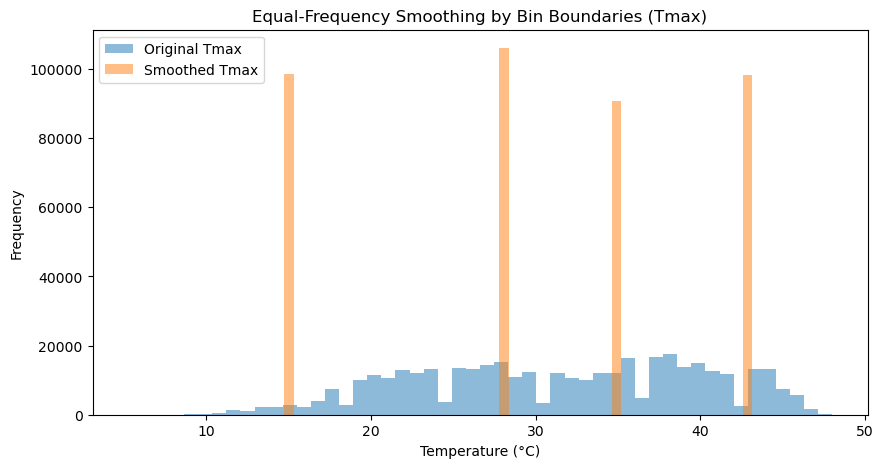

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(climate_df["tmax"], bins=50, alpha=0.5, label="Original Tmax")
plt.hist(climate_df["tmax_smoothed"], bins=50, alpha=0.5, label="Smoothed Tmax")
plt.title("Equal-Frequency Smoothing by Bin Boundaries (Tmax)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


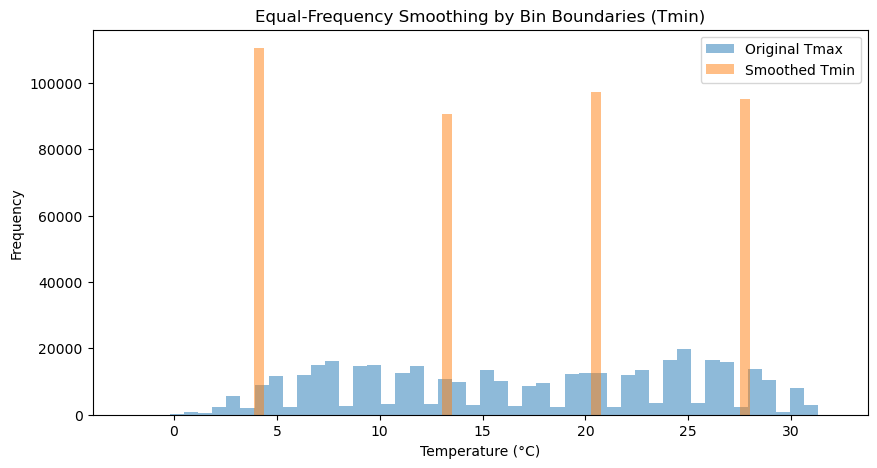

In [12]:

plt.figure(figsize=(10,5))
plt.hist(climate_df["tmin"], bins=50, alpha=0.5, label="Original Tmax")
plt.hist(climate_df["tmin_smoothed"], bins=50, alpha=0.5, label="Smoothed Tmin")
plt.title("Equal-Frequency Smoothing by Bin Boundaries (Tmin)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

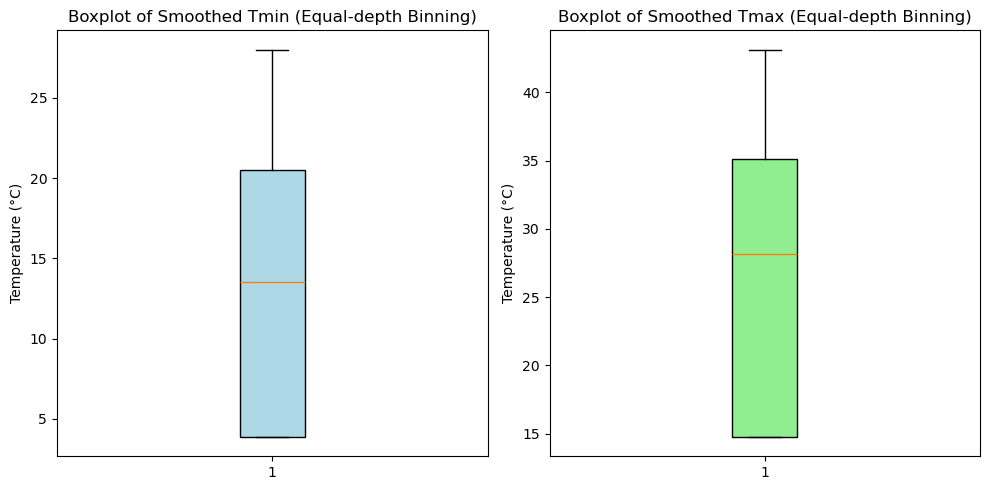

In [13]:
# Plot boxplots
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.boxplot(climate_df["tmin_smoothed"], patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Boxplot of Smoothed Tmin (Equal-depth Binning)")
plt.ylabel("Temperature (°C)")

plt.subplot(1,2,2)
plt.boxplot(climate_df["tmax_smoothed"], patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.title("Boxplot of Smoothed Tmax (Equal-depth Binning)")
plt.ylabel("Temperature (°C)")

plt.tight_layout()
plt.show()

In [14]:
# Create equal-frequency bins
climate_df["tmin_bin"] = pd.qcut(climate_df["tmin"], q=4, labels=["Very Cold", "Cold", "Warm", "Hot"])
climate_df["tmax_bin"] = pd.qcut(climate_df["tmax"], q=4, labels=["Cool", "Mild", "Hot", "Very Hot"])

# Check the bin distribution
print(climate_df["tmin_bin"].value_counts())
print(climate_df["tmax_bin"].value_counts())

tmin_bin
Very Cold    110523
Warm          97366
Hot           95036
Cold          90567
Name: count, dtype: int64
tmax_bin
Mild        106069
Cool         98537
Very Hot     98275
Hot          90611
Name: count, dtype: int64


In [15]:
climate_df.head()

,lon,lat,date,prec,tmax,tmin,tmax_smoothed,tmin_smoothed,tmin_bin,tmax_bin
0,-8.625,27.291667,2024-01-01,2.000,22.00,8.00,14.750,3.875,Very Cold,Cool
1,-8.625,27.291667,2024-02-01,0.425,25.00,11.00,28.125,13.500,Cold,Mild
2,-8.625,27.291667,2024-03-01,0.500,27.00,13.00,28.125,13.500,Cold,Mild
3,-8.625,27.291667,2024-04-01,1.500,32.00,18.00,28.125,20.500,Warm,Mild
4,-8.625,27.291667,2024-05-01,0.000,33.25,19.25,35.125,20.500,Warm,Hot


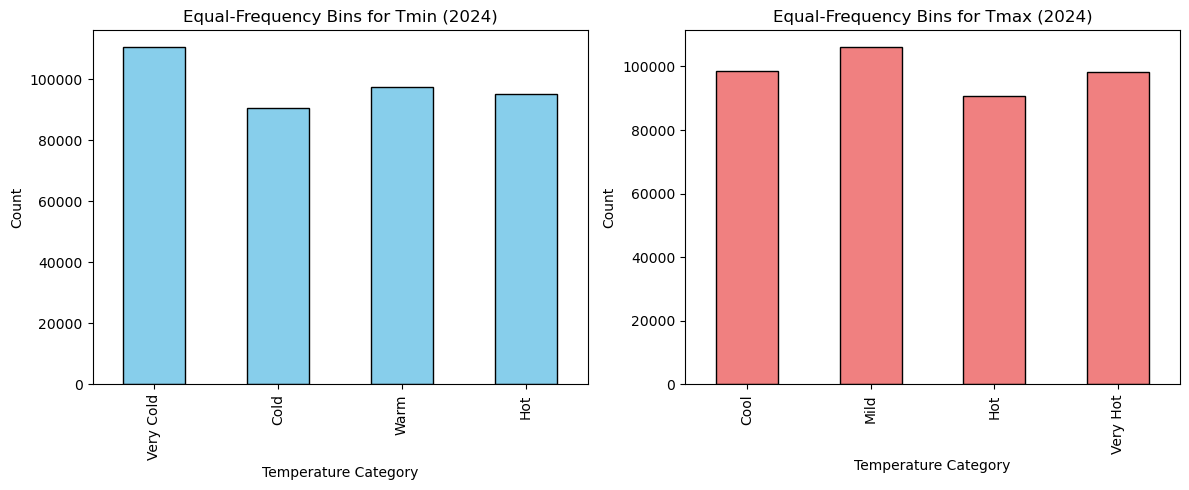

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Tmin bins
plt.subplot(1, 2, 1)
climate_df["tmin_bin"].value_counts().sort_index().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Equal-Frequency Bins for Tmin (2024)")
plt.xlabel("Temperature Category")
plt.ylabel("Count")

# Tmax bins
plt.subplot(1, 2, 2)
climate_df["tmax_bin"].value_counts().sort_index().plot(kind="bar", color="lightcoral", edgecolor="black")
plt.title("Equal-Frequency Bins for Tmax (2024)")
plt.xlabel("Temperature Category")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [17]:
bins = pd.qcut(climate_df["tmax"], q=4)
print(bins)

0         (5.249, 24.25]
1          (24.25, 32.0]
2          (24.25, 32.0]
3          (24.25, 32.0]
4          (32.0, 38.25]
               ...      
393487     (32.0, 38.25]
393488     (32.0, 38.25]
393489     (24.25, 32.0]
393490    (5.249, 24.25]
393491    (5.249, 24.25]
Name: tmax, Length: 393492, dtype: category
Categories (4, interval[float64, right]): [(5.249, 24.25] < (24.25, 32.0] < (32.0, 38.25] < (38.25, 48.0]]


## Precipitation preprocessing

### Mild transformation log(x+1)
**first try**
Apply a mild transformation to reduce skew (log(x+1) 1 to avoid log(0))

In [18]:
climate_df["precip_log"] = np.log(climate_df["prec"] + 1)
climate_df["precip_log"].head()
print("values greater than 0:",len(climate_df[climate_df["precip_log"]>=0]))
print("values less than 0:",len(climate_df[climate_df["precip_log"]<0]))


values greater than 0: 393492
values less than 0: 0


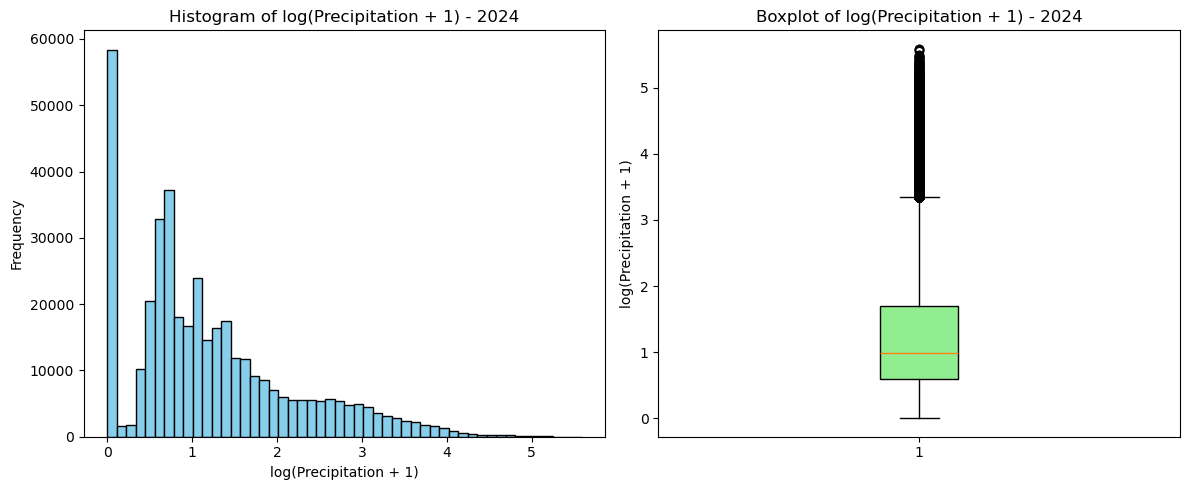

In [19]:


plt.figure(figsize=(12,5))

# Histogram
plt.subplot(1,2,1)
plt.hist(climate_df["precip_log"], bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of log(Precipitation + 1) - 2024")
plt.xlabel("log(Precipitation + 1)")
plt.ylabel("Frequency")

# Boxplot
plt.subplot(1,2,2)
plt.boxplot(climate_df["precip_log"], vert=True, patch_artist=True,
            boxprops=dict(facecolor="lightgreen", color="black"))
plt.title("Boxplot of log(Precipitation + 1) - 2024")
plt.ylabel("log(Precipitation + 1)")

plt.tight_layout()
plt.show()


### yeo_johnson transformation (best one)

Apply another method called yeo-johnson

**🌦️ Yeo–Johnson Transformation (for Precipitation)**

The **Yeo–Johnson transformation** is a *power transformation technique* used to **stabilize variance** and make a variable’s distribution closer to normal.  
It is particularly useful when the dataset contains **zero or positive values**.

In this project, the **precipitation data for 2024** contains many zeros and some extremely high values, leading to a **highly skewed distribution**.  
Applying the Yeo–Johnson transformation helps to:

- 📉 **Reduce the impact of extreme precipitation values (outliers).**  
- ⚖️ **Make the data more symmetric** and suitable for machine learning models that assume normally distributed inputs.  
- 🔢 **Preserve zero values** without needing to add a constant (unlike `log(x + 1)`).  

This transformation automatically estimates the **best parameter (λ)** that minimizes skewness in the data.

✅ As a result, the transformed precipitation values are **more balanced and easier for predictive models—such as those used in forest fire risk prediction—to interpret effectively.**


In [20]:
# Yeo-Johnson transform
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
climate_df["precip_yj"] = pt.fit_transform(climate_df[["prec"]])
print("values greater then 0",len(climate_df[climate_df["precip_yj"]>=0]))
print("values less then 0",len(climate_df[climate_df["precip_yj"]<0]))

values greater then 0 190661
values less then 0 202831


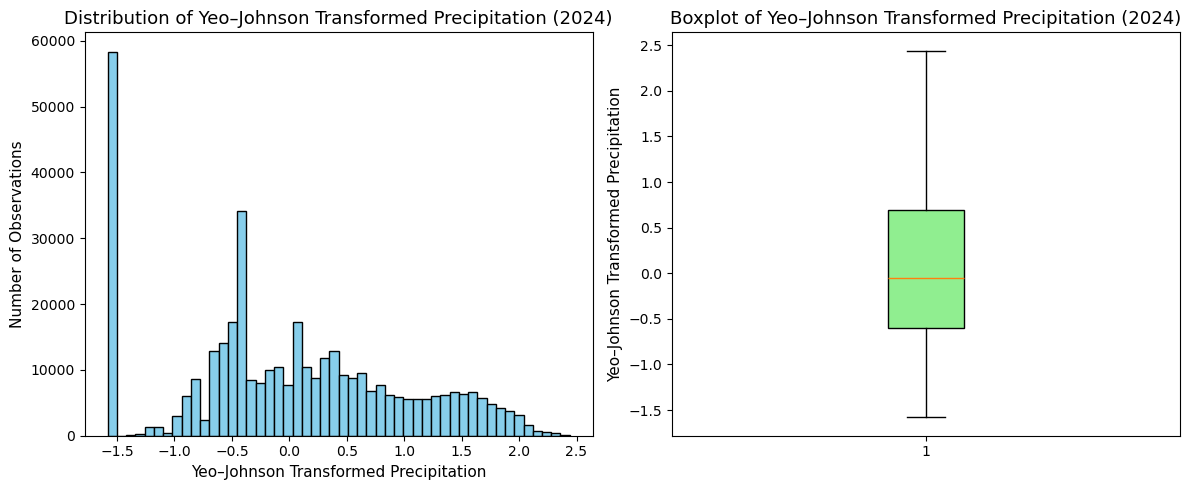

In [21]:

plt.figure(figsize=(12,5))

# Histogram
plt.subplot(1,2,1)
plt.hist(climate_df["precip_yj"], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Yeo–Johnson Transformed Precipitation (2024)", fontsize=13)
plt.xlabel("Yeo–Johnson Transformed Precipitation", fontsize=11)
plt.ylabel("Number of Observations", fontsize=11)

# Boxplot
plt.subplot(1,2,2)
plt.boxplot(climate_df["precip_yj"], vert=True, patch_artist=True,
            boxprops=dict(facecolor="lightgreen", color="black"))
plt.title("Boxplot of Yeo–Johnson Transformed Precipitation (2024)", fontsize=13)
plt.ylabel("Yeo–Johnson Transformed Precipitation", fontsize=11)

plt.tight_layout()
plt.show()



In [22]:
climate_df=climate_df.rename(columns={'lon':'longitude','lat':'latitude'})


In [23]:
climate_df.head()

,longitude,latitude,date,prec,tmax,tmin,tmax_smoothed,tmin_smoothed,tmin_bin,tmax_bin,precip_log,precip_yj
0,-8.625,27.291667,2024-01-01,2.000,22.00,8.00,14.750,3.875,Very Cold,Cool,1.098612,0.072962
1,-8.625,27.291667,2024-02-01,0.425,25.00,11.00,28.125,13.500,Cold,Mild,0.354172,-0.961386
2,-8.625,27.291667,2024-03-01,0.500,27.00,13.00,28.125,13.500,Cold,Mild,0.405465,-0.879155
3,-8.625,27.291667,2024-04-01,1.500,32.00,18.00,28.125,20.500,Warm,Mild,0.916291,-0.150974
4,-8.625,27.291667,2024-05-01,0.000,33.25,19.25,35.125,20.500,Warm,Hot,0.000000,-1.580815


In [24]:
climate_df.drop(columns=['prec', 'tmax', 'tmin', 'precip_log', 'tmax_bin', 'tmin_bin'])

,longitude,latitude,date,tmax_smoothed,tmin_smoothed,precip_yj
0,-8.625000,27.291667,2024-01-01,14.750,3.875,0.072962
1,-8.625000,27.291667,2024-02-01,28.125,13.500,-0.961386
2,-8.625000,27.291667,2024-03-01,28.125,13.500,-0.879155
3,-8.625000,27.291667,2024-04-01,28.125,20.500,-0.150974
4,-8.625000,27.291667,2024-05-01,35.125,20.500,-1.580815
...,...,...,...,...,...,...
393487,11.958333,23.541667,2024-08-01,35.125,20.500,0.392856
393488,11.958333,23.541667,2024-09-01,35.125,20.500,0.072962
393489,11.958333,23.541667,2024-10-01,28.125,20.500,-0.190105
393490,11.958333,23.541667,2024-11-01,14.750,3.875,-0.522507


In [26]:
from config import latitude_lower_bound
climate_df = climate_df[climate_df['latitude'] > latitude_lower_bound]
climate_df

,longitude,latitude,date,prec,tmax,tmin,tmax_smoothed,tmin_smoothed,tmin_bin,tmax_bin,precip_log,precip_yj
0,-8.625000,27.291667,2024-01-01,2.000,22.00,8.00,14.750,3.875,Very Cold,Cool,1.098612,0.072962
1,-8.625000,27.291667,2024-02-01,0.425,25.00,11.00,28.125,13.500,Cold,Mild,0.354172,-0.961386
2,-8.625000,27.291667,2024-03-01,0.500,27.00,13.00,28.125,13.500,Cold,Mild,0.405465,-0.879155
3,-8.625000,27.291667,2024-04-01,1.500,32.00,18.00,28.125,20.500,Warm,Mild,0.916291,-0.150974
4,-8.625000,27.291667,2024-05-01,0.000,33.25,19.25,35.125,20.500,Warm,Hot,0.000000,-1.580815
...,...,...,...,...,...,...,...,...,...,...,...,...
393127,11.541667,33.125000,2024-08-01,0.000,34.00,25.00,35.125,28.000,Hot,Hot,0.000000,-1.580815
393128,11.541667,33.125000,2024-09-01,10.475,31.75,23.00,28.125,20.500,Warm,Mild,2.440171,1.281001
393129,11.541667,33.125000,2024-10-01,11.325,30.00,21.00,28.125,20.500,Warm,Mild,2.511630,1.328027
393130,11.541667,33.125000,2024-11-01,8.050,24.25,15.00,14.750,13.500,Cold,Cool,2.202765,1.114109


In [28]:
climate_df.to_csv('../../data/pre-merge/climate.csv', index=False)